In [187]:
# Libraries
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pickle
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from dotenv import load_dotenv
from supabase import create_client
import os

In [188]:
# Read data
load_dotenv()

SUPABASE_URL = os.getenv("NEXT_PUBLIC_SUPABASE_URL")
SUPABASE_SERVICE_KEY = os.getenv("NEXT_PUBLIC_SUPABASE_SERVICE_KEY")

supabase = create_client(SUPABASE_URL, SUPABASE_SERVICE_KEY)

MAKE = "Ferrari"
min_observations = 20

response = (
    supabase.table("bat_completed_auctions")
    .select("year, model, mileage, normalized_color, transmission, sold_price, bid_amount, end_date, status")
    .eq("make", MAKE)
    .not_.is_("mileage", None)
    .not_.is_("transmission", None)
    .execute()
)
df = pd.DataFrame(response.data)

In [189]:
# Top Prices by model
prices = df[['model','sold_price']].groupby('model').mean().sort_values(by='sold_price',ascending=False)
print(prices)

                                    sold_price
model                                         
XJ220-N                               691234.0
XJ220                                 550000.0
SS100 3.5-Liter Project               315000.0
XKE Series I 3.8 Roadster Project     220000.0
XKE Series 1 Roadster 5-Speed         218888.0
...                                        ...
XKE Series I OTS 4.2L                      NaN
XKE Series I OTS 5-Speed                   NaN
XKE Series I Roadster 3.8L 5-Speed         NaN
XKE Series I Roadster 4.2L                 NaN
XKE Series I Roadster 4.2L 4-Speed         NaN

[729 rows x 1 columns]


In [190]:
# Price by model
display_p=df[['model','year','sold_price']]

fig=px.box(display_p,x="model",y="sold_price")
fig.update_layout(title_text='Price vs Model',xaxis_title="Model",yaxis_title="Average Price")

In [191]:
# Filter to models with more than min_observations
counts=df['model'].value_counts()
frequent_models = counts[counts >= min_observations].index

# Filter the data to frequent models
df = df[df['model'].isin(frequent_models)]
popular_labels=frequent_models

colors=['lightslategray',]*len(popular_labels)
colors[0]='crimson'

fig=go.Figure(data=[go.Bar(x=counts[:25],y=popular_labels,marker_color=colors,orientation='h')])
fig.update_layout(title_text='Most represented Models in the Dataset',xaxis_title="Count",yaxis_title="Model")

In [192]:
#distribution of number of cars over the years
dic = {1970+i : sum(df['year']==1970+i) for i in range(55)}
x_dic = [1970 + i for i in range(55)]
y_dic = [dic[1970 + i] for i in range(55)]

# Plot
fig = go.Figure([go.Bar(x=x_dic, y=y_dic)])

fig.update_layout(title="Car year distribution",
                  xaxis_title="Year",
                  yaxis_title="Count Cars sold")


fig.show()

In [193]:
# Distribution of transmission
data_pie = df['transmission'].value_counts()

fig = go.Figure(data=[go.Pie(labels=data_pie.index, values=data_pie.tolist(), textinfo='label+percent',insidetextorientation='radial')])

fig.update_traces(hole=.3, hoverinfo="label+percent+name")

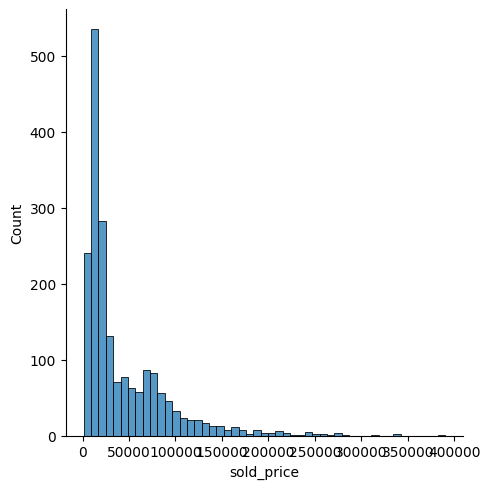

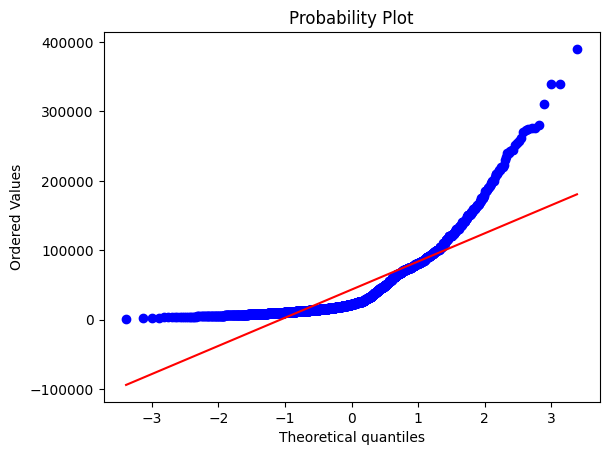

In [194]:
# Replace sold_price with bid_amount and remove outliers
df['sold_price'] = df['sold_price'].fillna(df['bid_amount'])
df = df.dropna()

# Remove outliers
price_threshold = 1000000
df.drop(df[df['sold_price'] >= price_threshold].index,inplace=True)

# Plot distribution of sold_price
sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'mileage'}>],
       [<Axes: title={'center': 'sold_price'}>,
        <Axes: title={'center': 'bid_amount'}>]], dtype=object)

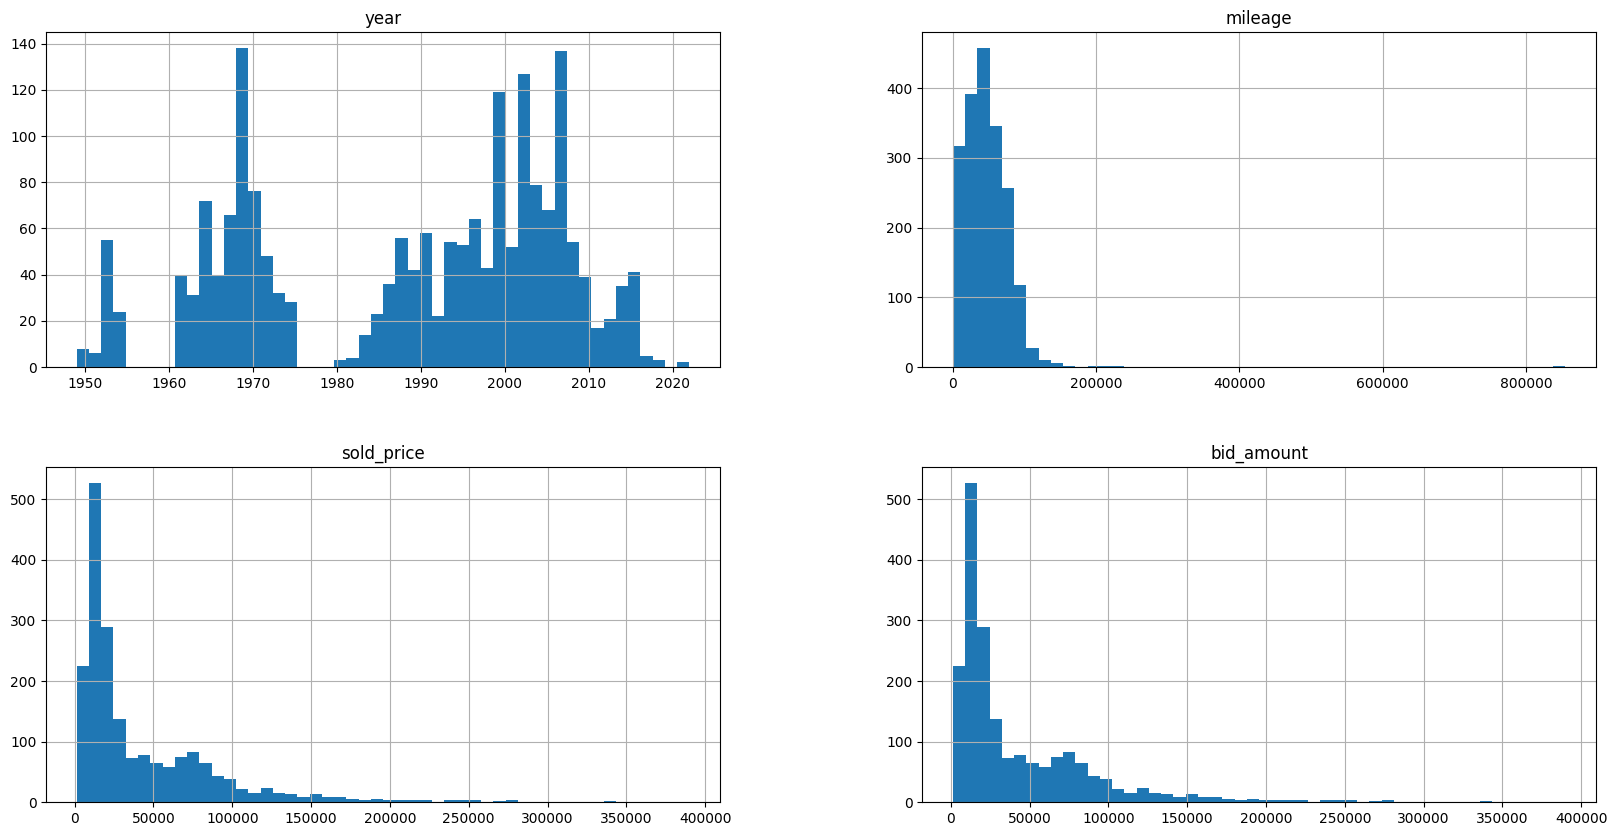

In [195]:
# Data distribution
df.hist(figsize=(20,10),bins = 50)

In [196]:
# Weight by recency
df['days_since_end'] = (pd.to_datetime(date.today()) - pd.to_datetime(df["end_date"])).dt.days
K = 1
T = 360
df['W'] = K*np.exp(-df['days_since_end']/T)


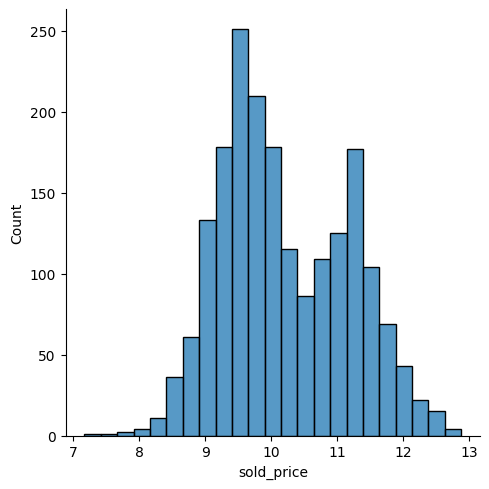

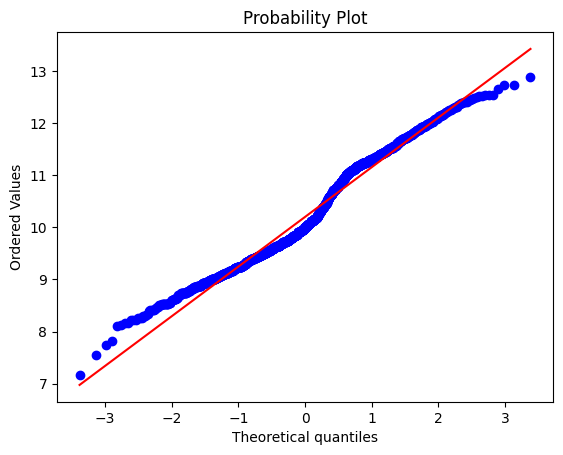

In [197]:
#Log transform sold_price & mileage
df['sold_price'] = np.log(df['sold_price'])
df['mileage'] = np.log1p(df['mileage'])

sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)

In [198]:
# Summarize transformed data
df.describe()

,year,mileage,sold_price,bid_amount,days_since_end,W
count,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000
mean,1988.455297,10.381296,10.198904,43216.951421,1043.039793,0.180022
std,18.084169,1.228311,0.964501,47232.610744,700.001142,0.229673
min,1949.000000,0.000000,7.170120,1300.000000,4.000000,0.000057
25%,1970.000000,10.126671,9.463221,12877.500000,499.500000,0.016390
50%,1994.000000,10.691968,9.998798,22000.000000,929.000000,0.075732
75%,2004.000000,11.082158,11.056124,63331.500000,1480.000000,0.249699
max,2022.000000,13.658858,12.873902,390000.000000,3520.000000,0.988950


In [199]:
# Prepare target and features
y = df["sold_price"]
X = df.drop(["sold_price","bid_amount","end_date", "status", "days_since_end"],axis=1)
X

,year,model,mileage,normalized_color,transmission,W
72,1974,E-Type Roadster V12 4-Speed,10.275086,Red,manual,0.396531
73,1974,E-Type Roadster V12 4-Speed,10.463132,Red,manual,0.317518
74,1973,E-Type Roadster V12 4-Speed,11.225257,Green,manual,0.199666
75,1974,E-Type Roadster V12 4-Speed,9.998843,Green,manual,0.178669
76,1974,E-Type Roadster V12 4-Speed,10.165890,Yellow,manual,0.152082
...,...,...,...,...,...,...
3740,2007,XKR Coupe,11.326608,Silver,automatic,0.026575
3741,2007,XKR Coupe,11.184435,Black,automatic,0.006757
3742,2008,XKR Coupe,10.968216,Green,automatic,0.036679
3743,2012,XKR Coupe,10.736418,Black,automatic,0.121778


In [200]:
# Encode categorical features
Lbl_model = LabelEncoder()
Lbl_color = LabelEncoder()
Lbl_trans = LabelEncoder()

#df.make=Lbl.fit_transform(df.make)
X.model=Lbl_model.fit_transform(df.model)
print("Model Mapping:", dict(zip(Lbl_model.classes_, Lbl_model.transform(Lbl_model.classes_))))
X.normalized_color=Lbl_color.fit_transform(df.normalized_color)
print("Color Mapping:", dict(zip(Lbl_color.classes_, Lbl_color.transform(Lbl_color.classes_))))
X.transmission =Lbl_trans.fit_transform(df.transmission)
print("Trans Mapping:", dict(zip(Lbl_trans.classes_, Lbl_trans.transform(Lbl_trans.classes_))))
X

Model Mapping: {'E-Type Roadster V12 4-Speed': 0, 'F-Type R Coupe': 1, 'F-Type V8 S Convertible': 2, 'S-Type R': 3, 'Super V8': 4, 'Vanden Plas': 5, 'XJ Vanden Plas': 6, 'XJ-S V12 Convertible': 7, 'XJ-SC V12': 8, 'XJ6': 9, 'XJ6 Vanden Plas': 10, 'XJ8': 11, 'XJ8L': 12, 'XJR': 13, 'XJR 100': 14, 'XJS': 15, 'XJS 2+2 Convertible': 16, 'XJS Convertible': 17, 'XJS V12 Convertible': 18, 'XJS V12 Coupe': 19, 'XK Convertible': 20, 'XK Coupe': 21, 'XK120 Fixed Head Coupe': 22, 'XK120 Roadster': 23, 'XK120 SE Roadster': 24, 'XK8 Convertible': 25, 'XK8 Coupe': 26, 'XKE 2+2': 27, 'XKE Coupe': 28, 'XKE Roadster': 29, 'XKE Roadster V12 4-Speed': 30, 'XKE Series 1.5 Roadster': 31, 'XKE Series I 3.8 Coupe': 32, 'XKE Series I 3.8 Roadster': 33, 'XKE Series I 4.2 Coupe': 34, 'XKE Series I 4.2 Roadster': 35, 'XKE Series I Roadster': 36, 'XKE Series II Coupe': 37, 'XKE Series II Coupe 4-Speed': 38, 'XKE Series II Roadster': 39, 'XKE Series II Roadster 4-Speed': 40, 'XKR': 41, 'XKR Convertible': 42, 'XKR Co

,year,model,mileage,normalized_color,transmission,W
72,1974,0,10.275086,17,1,0.396531
73,1974,0,10.463132,17,1,0.317518
74,1973,0,11.225257,10,1,0.199666
75,1974,0,9.998843,10,1,0.178669
76,1974,0,10.165890,22,1,0.152082
...,...,...,...,...,...,...
3740,2007,43,11.326608,18,0,0.026575
3741,2007,43,11.184435,1,0,0.006757
3742,2008,43,10.968216,10,0,0.036679
3743,2012,43,10.736418,1,0,0.121778


In [211]:
# Fit Model
# Features
# year	model	mileage	normalized_color	transmission

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = True)

car_model_rf = RandomForestRegressor(n_estimators=100, random_state=33, monotonic_cst = [0,0,-1,0,0,0])
car_model_rf.fit(X_train,y_train, sample_weight=X_train['W'])
print('Random Forest Regressor Train Score is : ' ,  car_model_rf.score(X_train, y_train))
print('Random Forest Regressor Test Score is : ' , car_model_rf.score(X_test, y_test)) 

predicted_rf = pd.DataFrame(car_model_rf.predict(X_test), index=X_test.index, columns=['predicted_rf'])
car_model_rf.feature_importances_


Random Forest Regressor Train Score is :  0.9091034618437511
Random Forest Regressor Test Score is :  0.7962144385570459


array([0.23876345, 0.03450511, 0.08542564, 0.02099165, 0.56949801,
       0.05081614])

In [202]:
# Inverse transform features
X_analysis = X_test.copy()
X_analysis.model = Lbl_model.inverse_transform(X_test.model)
X_analysis.normalized_color = Lbl_color.inverse_transform(X_test.normalized_color)
X_analysis.transmission = Lbl_trans.inverse_transform(X_test.transmission)
X_analysis

,year,model,mileage,normalized_color,transmission,W
1422,1990,XJS,6.908755,Red,automatic,0.003174
2031,1952,XK120 Roadster,9.798183,Gray,manual,0.026063
2037,1952,XK120 Roadster,11.277216,Gray,automatic,0.006775
3551,2005,XKR Convertible,10.239996,Black,automatic,0.608218
3111,1965,XKE Series I 4.2 Roadster,10.545368,Black,manual,0.131994
...,...,...,...,...,...,...
3669,2014,XKR Coupe,8.699681,Red,automatic,0.953875
3721,2004,XKR Coupe,11.373675,Black,automatic,0.022309
3736,2005,XKR Coupe,10.778977,Red,automatic,0.298695
2513,2007,XK Convertible,10.736418,Gold,automatic,0.217017


In [203]:
# Analyze Results: Add target and predicted values
X_analysis = pd.merge(y_test, X_analysis, how='inner', left_index=True, right_index=True)
X_analysis = pd.merge(X_analysis, predicted_rf, how='inner', left_index=True, right_index=True)
X_analysis.sold_price = np.exp(X_analysis.sold_price)
X_analysis.predicted_rf = np.exp(X_analysis.predicted_rf)
X_analysis.mileage = np.exp(X_analysis.mileage) - 1
X_analysis

,sold_price,year,model,mileage,normalized_color,transmission,W,predicted_rf
1422,10750.0,1990,XJS,1000.0,Red,automatic,0.003174,27729.205502
2031,88288.0,1952,XK120 Roadster,18000.0,Gray,manual,0.026063,87650.110173
2037,104000.0,1952,XK120 Roadster,79000.0,Gray,automatic,0.006775,13502.316737
3551,14900.0,2005,XKR Convertible,28000.0,Black,automatic,0.608218,17498.658140
3111,185000.0,1965,XKE Series I 4.2 Roadster,38000.0,Black,manual,0.131994,150945.038571
...,...,...,...,...,...,...,...,...
3669,44812.0,2014,XKR Coupe,6000.0,Red,automatic,0.953875,40276.508467
3721,13000.0,2004,XKR Coupe,87000.0,Black,automatic,0.022309,10442.550613
3736,18250.0,2005,XKR Coupe,48000.0,Red,automatic,0.298695,13903.827141
2513,15250.0,2007,XK Convertible,46000.0,Gold,automatic,0.217017,15588.835562


In [204]:
# Define price ranges
def getrange(Price):
    if (Price >= 0 and Price < 50000):
        return '0 - 50000'
    if (Price >= 50000 and Price < 100000):
        return '50000 - 100000'
    if (Price >= 100000 and Price < 150000):
        return '100000 - 150000'
    if (Price >= 150000 and Price < 200000):
        return '150000 - 200000'
    if (Price >= 200000 and Price < 250000):
        return '200000 - 250000'
    if (Price >= 250000 and Price < 300000):
        return '250000 - 300000'
    if (Price >= 300000 and Price < 350000):
        return '300000 - 350000'
    if (Price >= 350000):
        return 'Over 350000'
X_analysis['Price Range'] = X_analysis['sold_price'].apply(lambda x:getrange(x))

X_analysis['Price Range'].value_counts()

Price Range
0 - 50000          268
50000 - 100000      80
100000 - 150000     22
150000 - 200000      9
200000 - 250000      6
250000 - 300000      2
Name: count, dtype: int64

<Axes: xlabel='sold_price', ylabel='predicted_rf'>

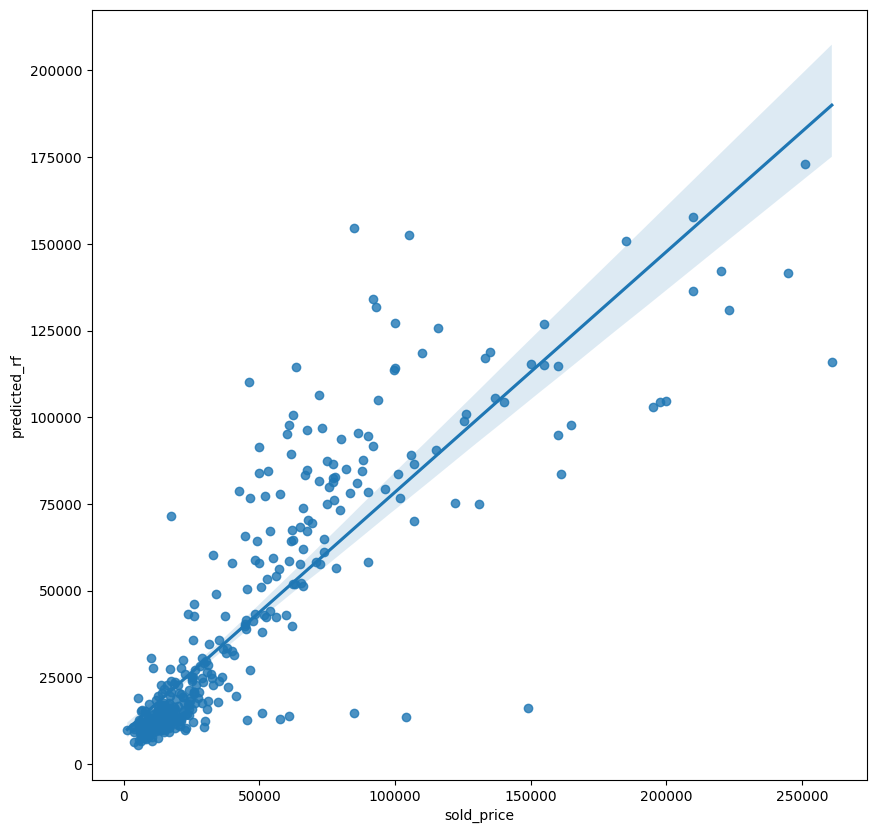

In [205]:
# Plot true vs predicted values scatter

plt.figure(figsize = (10, 10))
sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_rf)
#sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_xgb)

In [206]:
# Save model
today_date = date.today().strftime('%Y-%m-%d')
path = f"../models/{MAKE}"
if not os.path.exists(path):
    os.makedirs(path)

pickle.dump(car_model_rf, open(f'{path}/model.pkl','wb'))
pickle.dump(Lbl_model, open(f'{path}/labels_model.pkl','wb'))
pickle.dump(Lbl_color, open(f'{path}/labels_color.pkl','wb'))
pickle.dump(Lbl_trans, open(f'{path}/labels_transmission.pkl','wb'))

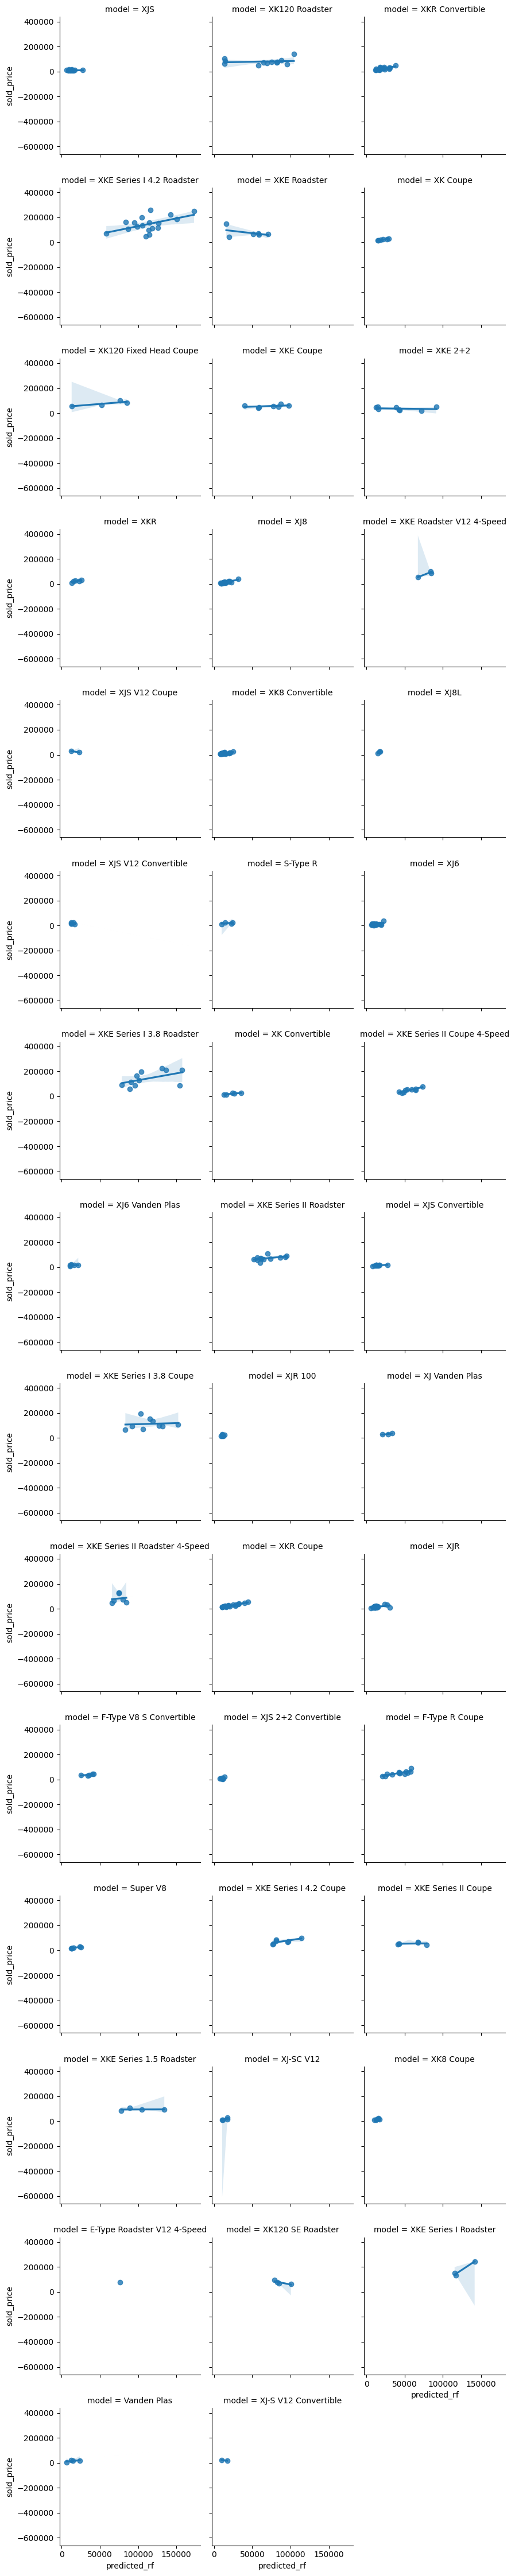

In [207]:
# Predicted vs Sold Price Scatter by model
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
g.map(sns.regplot, "predicted_rf", "sold_price")

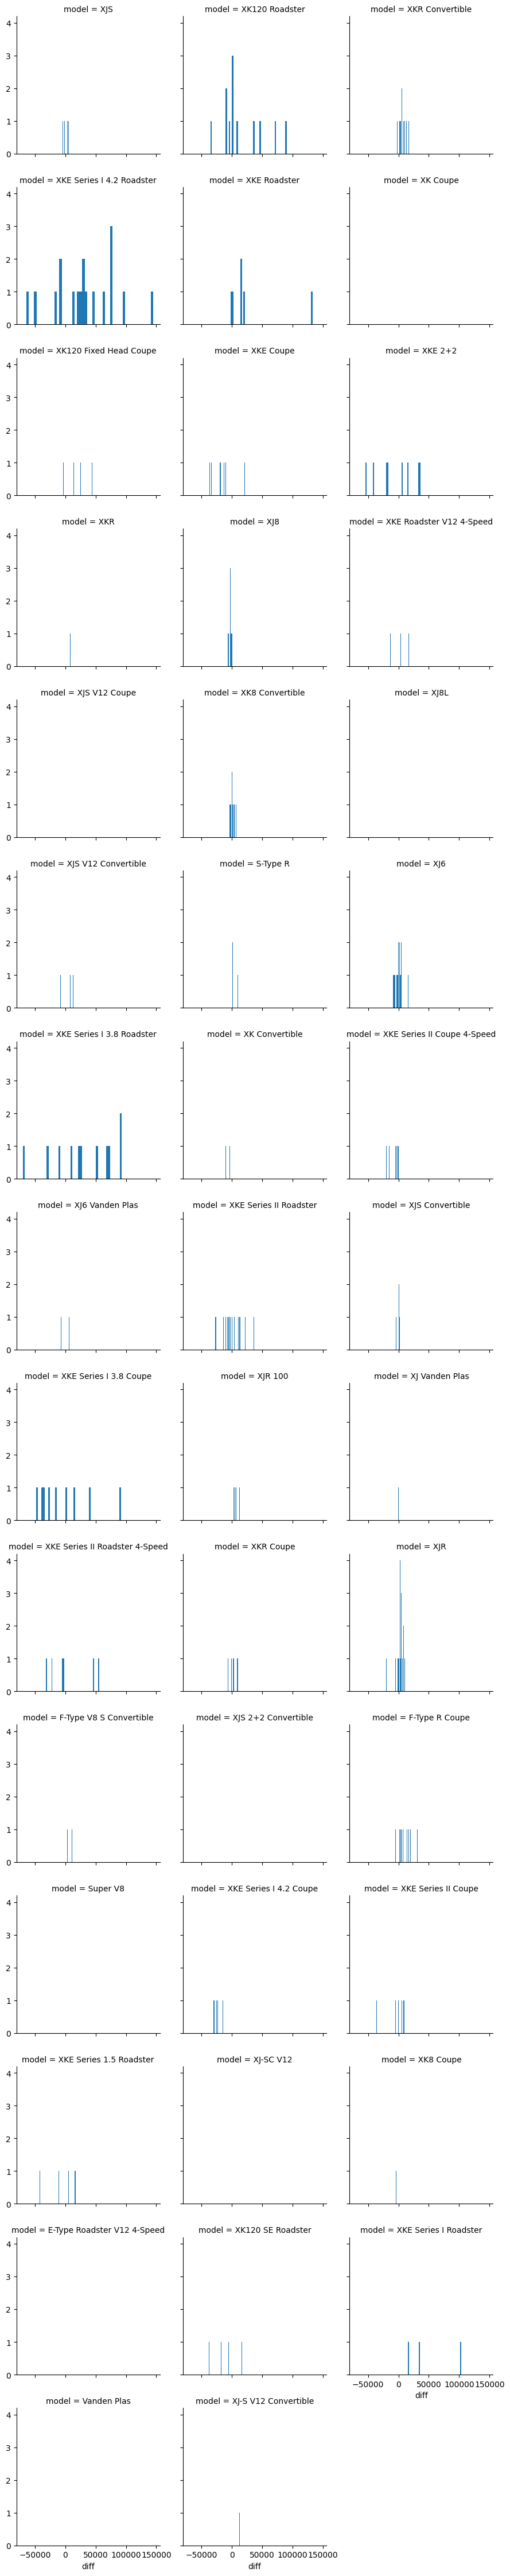

In [208]:
# Analyze Residuals by model
X_analysis['diff'] = X_analysis.sold_price - X_analysis.predicted_rf
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
g.map(plt.hist, "diff", bins = 50)


In [209]:
# Prediction function

def predict(year, model, mileage, color, transmission, carmodel, W):
    input_data = pd.DataFrame([[year, model, mileage, color, transmission, W]], 
                              columns=["year", "model", "mileage", "normalized_color", "transmission", "W"])
    input_data.model=Lbl_model.transform(input_data.model)
    input_data.normalized_color=Lbl_color.transform(input_data.normalized_color)
    input_data.transmission=Lbl_trans.transform(input_data.transmission)
    input_data.mileage = np.log1p(input_data.mileage)
    price_scaled = carmodel.predict(input_data)

    price = np.exp(price_scaled)
    
    return price[0].round(0)

In [212]:
# Run a prediction for a car over a range of mileage
mileage_range = np.linspace(0, 50000, 100)

predictions = []
for mileage in mileage_range:
    prediction = predict(
        year = 1992,
        model = "512 TR",
        mileage = mileage,
        color = "Black",
        transmission = "manual",
        carmodel = car_model_rf,
        W = 1
    )
    predictions.append(prediction)

predictions = pd.DataFrame(predictions, columns=["predicted"])
mileage_range = pd.DataFrame(mileage_range, columns=["mileage"])
predictions = pd.merge(predictions, mileage_range, how='inner', left_index=True, right_index=True)
plt.scatter(predictions["mileage"], predictions["predicted"])

ValueError: y contains previously unseen labels: '512 TR'